In [1]:
from pathlib import Path
import json
import cv2
import mediapipe as mp
import numpy as np
import math
from datetime import datetime as dt
import moviepy
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip, CompositeVideoClip, ImageClip, TextClip, VideoClip, concatenate_videoclips, clips_array
from tqdm import tqdm
print(moviepy.__version__)
data_path = Path('.').resolve() / 'videos'

1.0.3


In [2]:
def rename_files(data_path):
    x = dict()
    for i, (p, name, kor_name) in enumerate(zip(
            data_path.glob('*.mp4'), 
            ['hipjoint', 'shoulder', 'waist', 'trapezius'], 
            ['고관절', '어깨', '허리디스크', '승모근']
        )):
        pname = p.name.rstrip('.mp4')
        new_name = f'{i:02d}_{name}'
        x[new_name] = {'video_name': pname, 'kor_name': kor_name}
        p.rename(data_path / f'{new_name}.mp4')
    with (data_path / 'video_names.json').open('w') as file:
        json.dump(x, file)

# rename_files(data_path)

수정사항
* 영상을 살펴보니 00_hipjoint는 두 개의 동작이 있음
* 각 영상에는 설명부분과 운동하는 부분이 있음 > 영상 잘라야 할 필요성 있음
* 한 부위에 대해서 두 가지 방법을 알려주기도 함

영상 
* 우선 설명 보고 > 동작 3회 반복

1. `00_hipjoint.mp4`
    * `00:22`: 설명
    * `00:18.20-00:22.97`: 동작1 (15회 반복)
    * ~~`00:25-00:38`: 설명~~
    * ~~`00:33.11-00:39.98`: 동작2 (15회 반복) ~~
2. `01_shoulder.mp4`
    * `00:22-00:26`: 동작 (15회 5세트)
3. `02_waist.mp4`
    * `00:20-00:23`: 동작1 (12회)
    * `00:36-00:38`: 동작2 (12회), alternative
4. `03_trapezius.mp4`
    * `00:17-00:19`: 동작1 (10회)
    * `00:21-00:22`: 동작2 (10회)

https://zulko.github.io/moviepy

In [3]:
MP_DRAWING = mp.solutions.drawing_utils
MP_DRAWING_STYLE = mp.solutions.drawing_styles
MP_POSE = mp.solutions.pose

def calculate_angle(a, b, c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180.0:
        angle = 360-angle
        
    return angle 

def process_mediapipe(image):
    img_w, img_h, _ = image.shape
    with MP_POSE.Pose(
            min_detection_confidence=0.5, 
            min_tracking_confidence=0.5, 
            model_complexity=2, 
            enable_segmentation=True
        ) as POSE:
        # Make detection
        results = POSE.process(image)
        angles = np.zeros((1,4))
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            left_shoulder = [
                landmarks[MP_POSE.PoseLandmark.LEFT_SHOULDER.value].x*img_h, 
                landmarks[MP_POSE.PoseLandmark.LEFT_SHOULDER.value].y*img_w
            ]
            left_elbow = [
                landmarks[MP_POSE.PoseLandmark.LEFT_ELBOW.value].x*img_h,
                landmarks[MP_POSE.PoseLandmark.LEFT_ELBOW.value].y*img_w
            ]
            left_knee = [
                landmarks[MP_POSE.PoseLandmark.LEFT_KNEE.value].x*img_h,
                landmarks[MP_POSE.PoseLandmark.LEFT_KNEE.value].y*img_w
            ]
            left_hip = [
                landmarks[MP_POSE.PoseLandmark.LEFT_HIP.value].x*img_h,
                landmarks[MP_POSE.PoseLandmark.LEFT_HIP.value].y*img_w
            ]

            right_shoulder = [
                landmarks[MP_POSE.PoseLandmark.RIGHT_SHOULDER.value].x*img_h,
                landmarks[MP_POSE.PoseLandmark.RIGHT_SHOULDER.value].y*img_w
            ]
            right_elbow = [
                landmarks[MP_POSE.PoseLandmark.RIGHT_ELBOW.value].x*img_h,
                landmarks[MP_POSE.PoseLandmark.RIGHT_ELBOW.value].y*img_w
            ]
            right_knee = [
                landmarks[MP_POSE.PoseLandmark.RIGHT_KNEE.value].x*img_h,
                landmarks[MP_POSE.PoseLandmark.RIGHT_KNEE.value].y*img_w
            ]
            right_hip = [
                landmarks[MP_POSE.PoseLandmark.RIGHT_HIP.value].x*img_h,
                landmarks[MP_POSE.PoseLandmark.RIGHT_HIP.value].y*img_w
            ]
            
            # Calculate angle & Store in (1, 4) vector
            angles[0][0] = calculate_angle(left_elbow, left_shoulder, right_shoulder) #angle_1
            angles[0][1] = calculate_angle(right_elbow, right_shoulder, left_shoulder)
            angles[0][2] = calculate_angle(left_knee, left_hip, right_hip)
            angles[0][3] = calculate_angle(right_knee, right_hip, left_hip)         
        except:
            pass

        MP_DRAWING.draw_landmarks(
            image, results.pose_landmarks, MP_POSE.POSE_CONNECTIONS,
            MP_DRAWING.DrawingSpec(color=tuple(reversed((245,117,66))), thickness=2, circle_radius=2), 
            MP_DRAWING.DrawingSpec(color=tuple(reversed((245,66,230))), thickness=2, circle_radius=2)
        )
    return image, results, angles

In [ ]:
# videos = ['01_hipjoint', '02_waist', '03_trapezius']
# for video_file in videos:
#     clip = VideoFileClip(str(data_path / f'{video_file}.mp4')).without_audio()
#     all_angles = []
#     all_outputs = []
#     for image in tqdm(clip.iter_frames()):
#         image_output = image.copy()
#         image_output, results, angles = process_mediapipe(image=image_output)
#         all_angles.append(angles)
#         all_outputs.append(image_output)
#     new_clip = concatenate_videoclips([CompositeVideoClip([ImageClip(x, duration=1/clip.fps)]) for x in all_outputs])
#     new_video_name = f'{video_file}_gold.mp4'
#     new_clip.write_videofile(str(data_path / new_video_name), fps=clip.fps)

In [141]:
# def draw_line(mask_img, box, color):
#     bg_image = np.repeat(np.zeros_like(mask_img)[:, :, None], 4, axis=2)
#     cv2.rectangle(bg_image, box[:2], box[2:], COLOR_DICT[color], 2)
#     # bg_mask = (bg_image > 0).sum(2).astype(np.uint8) * 255
#     # single_blank = np.zeros((bg_image.shape[0], bg_image.shape[1], 1), dtype=bg_image.dtype)
#     # bg_image = np.concatenate((single_blank, bg_image), axis=-1)
#     # bg_image[:, :, 0] = bg_mask
#     return bg_image

# BOX_THRES = 30
# COLOR_DICT = {
#     'red': (255, 0, 0, 255),
#     'green': (0, 255, 0, 255)
# }
# videos = ['01_hipjoint', '02_waist', '03_trapezius']

# boxes = []
# for video_file in videos:
#     clip = VideoFileClip(str(data_path / f'{video_file}.mp4')).without_audio()
#     image = clip.get_frame(0)
#     img_h, img_w, _ = image.shape
#     image_output = image.copy()
#     image_output, results, angles = process_mediapipe(image=image_output)

#     mask_img = (results.segmentation_mask > 0.5).astype(np.uint8)
#     x, y, w, h = cv2.boundingRect(mask_img)
#     box = (
#         max(0, x-BOX_THRES),  # width_left
#         max(0, y-BOX_THRES),  # height_top
#         min(img_w, x+w+BOX_THRES),  # width_right
#         min(img_h, y+h+BOX_THRES)  # height_bottom
#     )
#     boxes.append(box)

#     # red_rgba = draw_line(mask_img, box, color='red')
#     # red_rgba = cv2.cvtColor(red_rgba, cv2.COLOR_BGRA2RGBA)
#     # cv2.imwrite(f'{video_file}_mask_red.png', red_rgba)

#     # green_rgba = draw_line(mask_img, box, color='green')
#     # green_rgba = cv2.cvtColor(green_rgba, cv2.COLOR_BGRA2RGBA)
#     # cv2.imwrite(f'{video_file}_mask_green.png', green_rgba)

In [19]:
clip = VideoFileClip(str(data_path / '00_shoulder.mp4'))
# (154, 208, 310, 720)
clip_resized = clip.resize(height=720) # make the height 360px ( According to moviePy documenation The width is then computed so that the width/height ratio is conserved.)
clip_resized.write_videofile("00_shoulder_720p.mp4")

Moviepy - Building video 00_shoulder_720p.mp4.
MoviePy - Writing audio in 00_shoulder_720pTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video 00_shoulder_720p.mp4



Moviepy - Done !
Moviepy - video ready 00_shoulder_720p.mp4


In [ ]:
clip.crop(x1=50, x2=350, y1=200, y2=)

(520, 310, 3)
Moviepy - Building video 00_shoulder_crop_720p.mp4.
MoviePy - Writing audio in 00_shoulder_crop_720pTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video 00_shoulder_crop_720p.mp4



Moviepy - Done !
Moviepy - video ready 00_shoulder_crop_720p.mp4


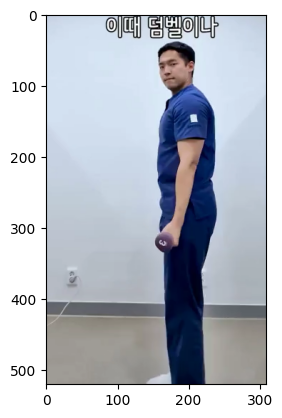

In [20]:
clip = VideoFileClip(str(data_path / '00_shoulder_720p.mp4'))
clip = clip.crop(x1=40, x2=350, y1=200, y2=720)
frame = clip.get_frame(0)
img_h, img_w, _ = frame.shape
print(frame.shape)
plt.imshow(frame)
clip.write_videofile("00_shoulder_crop_720p.mp4")

In [29]:
clip = VideoFileClip(str(data_path / '00_shoulder_crop_720p.mp4'))
frame = clip.get_frame(0)
img_h, img_w, _ = frame.shape
print(frame.shape, clip.fps)

(520, 310, 3) 29.97002997002997


In [30]:
BOX_THRES = 30
image = frame.copy()
image, results, angles = process_mediapipe(image)
mask_img = (results.segmentation_mask > 0.5).astype(np.uint8)
x, y, w, h = cv2.boundingRect(mask_img)
box = (
    max(0, x-BOX_THRES),  # width_left
    max(0, y-BOX_THRES),  # height_top
    min(img_w, x+w+BOX_THRES),  # width_right
    min(img_h, y+h+BOX_THRES)  # height_bottom
)
box

(122, 7, 270, 520)

In [28]:
(1280 - 310) / 2

485.0

In [26]:
(720 - 520) / 2

100.0

In [24]:
from tqdm import tqdm

In [14]:
all_outputs = []
for image in tqdm(clip.iter_frames()):
    image_output = image.copy()
    image_output, results, angles = process_mediapipe(image=image_output)
    all_outputs.append(image_output)
new_clip = concatenate_videoclips([CompositeVideoClip([ImageClip(x, duration=1/clip.fps)]) for x in all_outputs])
new_video_name = f'00_shoulder_gold_720p.mp4'
new_clip.write_videofile(str(data_path / new_video_name), fps=clip.fps)

101it [00:52,  1.92it/s]


Moviepy - Building video /Users/simon/code/ambient_ai2022/project/videos/00_shoulder_gold.mp4.
Moviepy - Writing video /Users/simon/code/ambient_ai2022/project/videos/00_shoulder_gold.mp4



Moviepy - Done !
Moviepy - video ready /Users/simon/code/ambient_ai2022/project/videos/00_shoulder_gold.mp4


In [10]:
BOX_THRES = 30
image = frame.copy()
image, results, angles = process_mediapipe(image)
mask_img = (results.segmentation_mask > 0.5).astype(np.uint8)
x, y, w, h = cv2.boundingRect(mask_img)
box = (
    max(0, x-BOX_THRES),  # width_left
    max(0, y-BOX_THRES),  # height_top
    min(img_w, x+w+BOX_THRES),  # width_right
    min(img_h, y+h+BOX_THRES)  # height_bottom
)
box

(154, 208, 310, 720)

In [25]:
clips = []
data = [
    ('Ready for \nthe next set', 'red', 30, 3),
    ('3', 'red', 70, 1),
    ('2', 'red', 70, 1),
    ('1', 'red', 70, 1),
]
bg_white = np.ones_like(frame) * 255
for k, (txt, color, fontsize, duration) in enumerate(data):
    txt_clip = TextClip(txt, fontsize=fontsize, color=color, bg_color='transparent').set_pos('center')
    bg_clip = ImageClip(frame)
    wait_clip = CompositeVideoClip([bg_clip, txt_clip]).set_duration(duration)
    wait_clip = wait_clip
    clips.append(wait_clip)

concat_clip = concatenate_videoclips(clips, method='compose').fadein(1)
# concat_clip = concatenate_videoclips([concat_clip, clip], method='compose')
new_video_name = f'intermediate.mp4'
concat_clip.write_videofile(new_video_name, fps=clip.fps)

Moviepy - Building video intermediate.mp4.
Moviepy - Writing video intermediate.mp4



Moviepy - Done !
Moviepy - video ready intermediate.mp4


In [118]:
bg_mask = (red_image > 0).sum(2).astype(np.uint8)

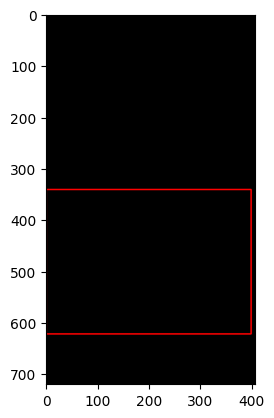

In [91]:
bg_image = np.repeat(np.zeros_like(mask_img)[:, :, None], 3, axis=2)
cv2.rectangle(bg_image, box[:2], box[2:], COLOR_DICT['red'], 2)
bg_mask = (bg_image > 0).sum(2).astype(np.uint8)
plt.imshow(bg_image)
single_blank = np.zeros((bg_image.shape[0], bg_image.shape[1], 1), dtype=bg_image.dtype)
bg_image = np.concatenate((single_blank, bg_image), axis=-1)
bg_image[:, :, 0] = bg_mask

In [ ]:
bg_image = np.repeat(np.zeros_like(mask_img)[:, :, None], 4, axis=2)
color = COLOR_DICT['red']
cv2.rectangle(image, box[:2], box[2:], COLOR_DICT['red'], 2)
# x = np.repeat(bg_image[:, :, :, None], , axis=2)
cv2.imwrite(f'{video_file}_mask_rec_red.png', bg_image)

In [43]:


first_img = clip.get_frame(0)

pose = mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=2, enable_segmentation=True) #complexity = 0, 1, 2 (2=> more sophisticated results)

img = cv2.cvtColor(first_img.copy(), cv2.COLOR_BGR2RGB) #BGR to RGB 
results = pose.process(img) #pose processing for getting results

In [60]:
def draw_background(x):
    n_channels = 4
    img_height, img_width = x.shape
    transparent_img = np.zeros((img_height, img_width, n_channels), dtype=np.uint8)
    return transparent_img

6 357 400 168
min: (6, 357)
max: (406, 525)


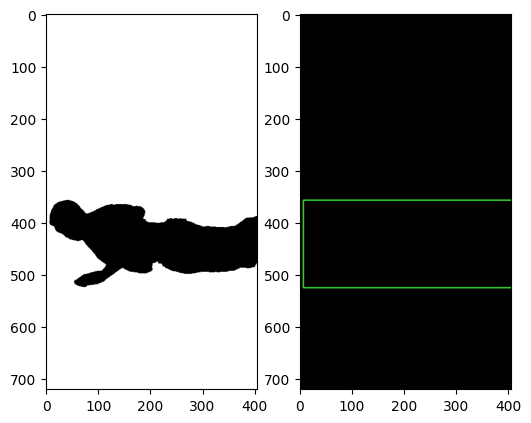

In [128]:
thres = 0.5

mask_img = (results.segmentation_mask > thres).astype(np.uint8)
bg = draw_background(mask_img)
x = np.repeat(mask_img[:, :, None], 3, axis=2)
# cv2.imwrite(f'{video_file}_mask.png', x[:, :, :, None])

x,y,w,h = cv2.boundingRect(mask_img)
print(x,y,w,h)
min_coor = (x, y)
max_coor = (x+w,y+h)
print("min:", min_coor)
print("max:", max_coor)


# 저장 

# red
bg_image = np.repeat(np.zeros_like(mask_img)[:, :, None], 4, axis=2)
color = tuple(reversed((220,20,60)))
# color = (220,20,60)
cv2.rectangle(bg_image, min_coor, max_coor, color, 2)
# x = np.repeat(bg_image[:, :, :, None], , axis=2)
cv2.imwrite(f'{video_file}_mask_rec_red.png', bg_image)

# green
bg_image = np.repeat( np.zeros_like(mask_img)[:, :, None], 3, axis=2)
color = tuple(reversed((50,205,50)))
cv2.rectangle(bg_image, min_coor, max_coor, color, 2)

bg_mask = (bg_image > 0).sum(2).astype(np.uint8)
bg_image = np.concatenate((bg_image, np.zeros((bg_image.shape[0], bg_image.shape[1], 1), dtype=bg_image.dtype)), axis=-1)
bg_image[:, :, -1] = bg_mask

cv2.imwrite(f'{video_file}_mask_rec_green.png', bg_image)

fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].imshow(mask_img, cmap='binary')
axes[1].imshow(bg_image[:, :, :3])

In [121]:
# green
bg_image = np.repeat(np.zeros_like(mask_img)[:, :, None], 3, axis=2)
# bg_image = np.zeros_like(mask_img)
color = tuple(reversed((50,205,50)))

# color = (50,205,50)
bg_image = cv2.rectangle(bg_image, min_coor, max_coor, color, 2)

In [122]:
bg_image.shape[:2]

(720, 406)

In [126]:
np.concatenate((bg_image, np.zeros((bg_image.shape[0], bg_image.shape[1], 1), dtype=bg_image.dtype)), axis=-1).shape

(720, 406, 4)

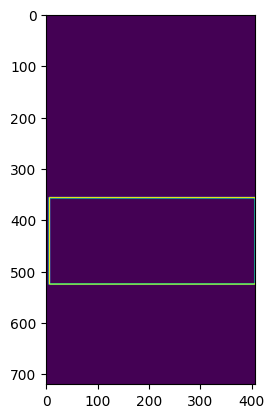

In [127]:
bg_mask = (bg_image > 0).sum(2).astype(np.uint8)
bg_image = np.concatenate((bg_image, np.zeros((bg_image.shape[0], bg_image.shape[1], 1), dtype=bg_image.dtype)), axis=-1)
bg_image[:, :, -1] = bg_mask
plt.imshow(bg_mask)

## Add new video

In [3]:
def add_video_data(num_repeat=15, num_times=3):
    with (data_path / 'video_names.json').open('r') as file:
        data = json.load(file)

    video_action_data = {
        '00_hipjoint': [('00:19-00:24', num_repeat, num_times), ('00:38-00:44', num_repeat, num_times)],
        '01_shoulder': [('00:22-00:26', num_repeat, num_times)],
        '02_waist': [('00:22-00:26', num_repeat, num_times)],
        '03_trapezius': [('00:17-00:19', num_repeat, num_times), ('00:21-00:22', num_repeat, num_times)],
    }

    for k in data.keys():
        data[k]['acts'] = video_action_data[k]
    with (data_path / 'video_data.json').open('w') as file:
        json.dump(data, file)

add_video_data(num_repeat=5, num_times=3)

In [4]:
DATA_PATH = Path('.').resolve() / 'videos'
MP_DRAWING = mp.solutions.drawing_utils
MP_DRAWING_STYLE = mp.solutions.drawing_styles
MP_POSE = mp.solutions.pose
FMT = '%M:%S'

with (DATA_PATH / 'video_data.json').open('r') as file: 
    video_data = json.load(file)

In [12]:
from moviepy.editor import VideoFileClip, CompositeVideoClip, ImageClip, TextClip, VideoClip, concatenate_videoclips, clips_array
# from textClip import TextClip
from collections import defaultdict

In [15]:
def get_wait_clip():
    # fix the issue if TextClip is not working due to ImageMagic, `convert --version`
    # https://github.com/Zulko/moviepy/issues/401#issuecomment-278679961
    wait_clips = []
    # (text, color, font_size, duration)
    data = [
        ('Please rest \nfor 5 seconds', 'black', 25, 4),
        ('Ready for \nthe next set', 'red', 25, 3),
        ('3', 'red', 70, 1),
        ('2', 'red', 70, 1),
        ('1', 'red', 70, 1),
    ]
    total_wait_time = 0
    bg_white = np.ones_like(bg_img) * 255
    for k, (txt, color, fontsize, duration) in enumerate(data):
        txt_clip = TextClip(txt, fontsize=fontsize, color=color, bg_color='transparent').set_pos('center')
        bg = bg_white if k == 0 else bg_img
        bg_clip = ImageClip(bg)
        wait_clip = CompositeVideoClip([bg_clip, txt_clip]).set_duration(duration)
        total_wait_time += duration
        if k == 0:
            wait_clip = wait_clip.fadein(0.5).fadeout(0.5)
            total_wait_time += 1
        wait_clips.append(wait_clip)
    return concatenate_videoclips(wait_clips), total_wait_time

def restart_clip(bg_img):
    wait_clips = []
    data = [
        ('Ready for \nthe next set', 'red', 720, 3),
        ('3', 'red', 70, 1),
        ('2', 'red', 70, 1),
        ('1', 'red', 70, 1),
    ]
    bg_white = np.ones_like(bg_img) * 255
    for k, (txt, color, fontsize, duration) in enumerate(data):
        txt_clip = TextClip(txt, fontsize=fontsize, color=color, bg_color='transparent').set_pos('center')
        bg_clip = ImageClip(bg_img)
        wait_clip = CompositeVideoClip([bg_clip, txt_clip]).set_duration(duration)
        wait_clip = wait_clip.fadein(0.5)
        wait_clips.append(wait_clip)
    return wait_clip

def get_intermediate_count_clip(sub_clip, count):
    txt_clip = TextClip(f'{count}', fontsize=70, color='red', bg_color='transparent')\
        .set_pos((0.1, 0.1), relative=True).set_duration(sub_clip.duration)
    inter_clip = CompositeVideoClip([sub_clip, txt_clip])
    return inter_clip


In [ ]:
for video_path in sorted(data_path.glob('*.mp4')):
    print(video_path.name)
    clip = VideoFileClip(str(video_path)).without_audio()
    print(clip.size)

In [ ]:
def restart_clip(bg_img):
    wait_clips = []
    data = [
        ('Ready for \nthe next set', 'red', 720, 3),
        ('3', 'red', 70, 1),
        ('2', 'red', 70, 1),
        ('1', 'red', 70, 1),
    ]
    bg_white = np.ones_like(bg_img) * 255
    for k, (txt, color, fontsize, duration) in enumerate(data):
        txt_clip = TextClip(txt, fontsize=fontsize, color=color, bg_color='transparent').set_pos('center')
        bg_clip = ImageClip(bg_img)
        wait_clip = CompositeVideoClip([bg_clip, txt_clip]).set_duration(duration)
        wait_clip = wait_clip.fadein(0.5)
        wait_clips.append(wait_clip)
    return wait_clip

In [11]:
def get_total_seconds(x):
    datetime_obj = dt.strptime(x, FMT)
    return 60*datetime_obj.minute + datetime_obj.second

def extract_acts(video_path, video_data):
    video_name = video_path.name.rstrip('.mp4')
    clip = VideoFileClip(str(video_path)).without_audio()
    acts_times = video_data[video_name]['acts']
    video_clips_dict = defaultdict(dict)
    for i, (time, num_repeat, num_times) in enumerate(acts_times):
        new_clips = []
        timestamps = []
        t_start, t_end = map(get_total_seconds, time.split('-'))
        sub_clip = clip.subclip(t_start=t_start, t_end=t_end)
        bg_image = sub_clip.get_frame(0)
        # pipeline for mediappipe inference



        # 
        wait_clip, total_wait_time = get_wait_clip(bg_img=bg_image)
        timestamps.append((t_end-t_start)*num_repeat)
        for count in range(1, num_repeat+1):
            inter_clip = get_intermediate_count_clip(sub_clip, count=count)
            new_clips.append(inter_clip)
        # wait clips
        timestamps.append(total_wait_time)
        new_clips.append(wait_clip)
        concat_clip = concatenate_videoclips(new_clips, method='compose')
        new_video_name = f'{video_name}_sub{i}.mp4'
        concat_clip.write_videofile(new_video_name, fps=clip.fps)
        video_clips_dict[new_video_name]['timestamps'] = timestamps
    return video_clips_dict

In [10]:
video_path = sorted(data_path.glob('*.mp4'))[1]
video_clips_dict = extract_acts(video_path, video_data)

Moviepy - Building video 01_shoulder_sub0.mp4.
Moviepy - Writing video 01_shoulder_sub0.mp4



Moviepy - Done !
Moviepy - video ready 01_shoulder_sub0.mp4


In [39]:
clip = VideoFileClip(str(video_path))


In [40]:
x = clip.get_frame(0)
f = get_wait_clip(bg_img=x)
f.write_videofile("test.mp4", fps=clip.fps)

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


In [42]:
video_name = '00_hipjoint'

In [56]:
txt_clip = TextClip(f'{1}', fontsize=70, color='red', bg_color='transparent').set_pos('top', 'left').set_duration(sub_clip.duration)
inter_clip = CompositeVideoClip([sub_clip, txt_clip])
inter_clip.write_videofile("test.mp4", fps=clip.fps)

In [76]:
video_name = video_path.name.rstrip('.mp4')
clip = VideoFileClip(str(video_path))
acts_times = video_data[video_name]['acts']

In [77]:
acts_times

[['00:19-00:24', 5, 3], ['00:38-00:44', 5, 3]]

In [85]:
video_name = video_path.name.rstrip('.mp4')
clip = VideoFileClip(str(video_path))
acts_times = video_data[video_name]['acts']
for i, (time, num_repeat, num_times) in enumerate(acts_times):
    new_clips = []
    timestamps = []
    t_start, t_end = map(get_total_seconds, time.split('-'))
    sub_clip = clip.subclip(t_start=t_start, t_end=t_end)
    bg_image = sub_clip.get_frame(0)
    wait_clip, total_wait_time = get_wait_clip(bg_img=bg_image)
    # for k in range(num_times):
    #     timestamps.append((t_end-t_start)*num_repeat)
    #     for count in range(1, num_repeat+1):
    #         inter_clip = get_intermediate_count_clip(sub_clip, count=count)
    #         new_clips.append(inter_clip)
    #     timestamps.append(total_wait_time)
    #     new_clips.append(wait_clip)
    # concat_clip = concatenate_videoclips(new_clips, method='compose')
    # concat_clip.write_videofile(f'{video_name}_sub{i}.mp4', fps=clip.fps)
    break

In [86]:
inter_clip = get_intermediate_count_clip(sub_clip, count=1)

In [ ]:
inter_clip.write_videofile('test.mp4', fps=clip.fps)

In [ ]:
txt_clip = TextClip(f'{count}', fontsize=70, color='red', bg_color='transparent')\
    .set_pos((0.1, 0.9), relative=True).set_duration(sub_clip.duration)
inter_clip = CompositeVideoClip([sub_clip, txt_clip])

In [83]:
new_clips

In [51]:
concat_clip = concatenate_videoclips(new_clips, method='compose')
concat_clip.write_videofile("test.mp4", fps=clip.fps)

Moviepy - Building video test.mp4.
MoviePy - Writing audio in testTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


In [13]:
f.write_videofile('test.mp4', fps=clip.fps)

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


In [28]:
import matplotlib.pyplot as plt

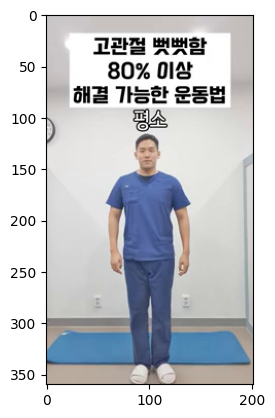

In [29]:
plt.imshow(x)